In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def print_metrics(y_true, y_pred, y_proba=None, title=None):
    # y_true, y_pred: истинные и предсказанные метки классов (например, 0/1)
    # y_proba: вероятность класса 1 (нужна, если хотим посчитать ROC-AUC)
    if title:
        print(title)
    # Accuracy – доля правильных ответов (хороша как “первая” метрика, но не всегда достаточно)
    acc = accuracy_score(y_true, y_pred)
    # F1 – баланс precision/recall (часто полезнее accuracy при дисбалансе классов)
    f1 = f1_score(y_true, y_pred)
    print(f"accuracy = {acc:.4f}")
    print(f"f1       = {f1:.4f}")
    if y_proba is not None:
        # ROC-AUC корректно считать по вероятностям/скорингам, а не по “жёстким” классам
        try:
            auc = roc_auc_score(y_true, y_proba)
            print(f"roc_auc  = {auc:.4f}")
        except Exception:
            # Иногда AUC может не считаться (например, если в y_true один класс)
            pass
    print("confusion_matrix:")
    print(confusion_matrix(y_true, y_pred))
    print()


def plot_decision_boundary_2d(model, X, y, title=None, steps=300):
    # Работает только для 2D признаков (чисто для визуального понимания)
    # Идея: строим сетку точек, предсказываем класс в каждой – получаем “карту” решений
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps),
                         np.linspace(y_min, y_max, steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, zz, alpha=0.25)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20)
    if title:
        plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

In [3]:
df = pd.read_csv('S06-hw-dataset-01.csv')

df.head()

,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
0,1,-0.946058,-0.070313,1.824445,-2.754422,0.808865,-0.111094,-0.268950,-3.078210,0.801275,...,-1.616515,-1.989464,1.407390,-0.218362,2.016052,0,2,3,33,0
1,2,-2.484027,0.739378,1.596908,-2.586479,-0.033225,-3.054412,-4.706908,-9.795169,0.145911,...,-1.727040,-0.583997,1.136761,0.285978,-0.310879,2,2,2,102,1
2,3,1.522629,7.159635,-0.564903,-4.493110,1.623610,5.450187,-0.974595,-5.189589,1.600591,...,0.524408,2.022430,1.278358,-0.850547,0.847457,1,0,2,3,0
3,4,0.463373,-1.073908,1.752813,0.362786,2.790872,4.082385,0.322283,3.390984,-0.033929,...,2.399834,-1.431576,-0.746987,0.049639,2.414689,1,0,1,50,0
4,5,3.188390,-4.701692,-0.689918,-0.448995,0.373821,-3.275363,-1.760931,0.923689,0.537345,...,-2.183407,-2.896590,2.440343,-1.097168,1.457323,1,2,3,81,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             12000 non-null  int64  
 1   num01          12000 non-null  float64
 2   num02          12000 non-null  float64
 3   num03          12000 non-null  float64
 4   num04          12000 non-null  float64
 5   num05          12000 non-null  float64
 6   num06          12000 non-null  float64
 7   num07          12000 non-null  float64
 8   num08          12000 non-null  float64
 9   num09          12000 non-null  float64
 10  num10          12000 non-null  float64
 11  num11          12000 non-null  float64
 12  num12          12000 non-null  float64
 13  num13          12000 non-null  float64
 14  num14          12000 non-null  float64
 15  num15          12000 non-null  float64
 16  num16          12000 non-null  float64
 17  num17          12000 non-null  float64
 18  num18 

In [5]:
df.describe()

,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,0.013705,-0.005278,-0.002357,0.038404,-0.006301,-0.865297,-0.702877,-0.290694,-0.008154,...,-0.323083,-1.314833,0.319798,-0.002742,0.027459,0.988750,1.990167,1.506833,36.083833,0.323417
std,3464.24595,2.096534,3.544498,1.004417,2.087318,1.007329,3.888966,1.989513,3.455981,0.996677,...,2.167066,3.731384,2.223649,0.996454,1.882359,0.815687,1.411643,1.121558,25.061218,0.467800
min,1.00000,-8.155181,-14.605579,-4.374043,-7.753301,-3.999332,-15.238402,-7.377252,-13.853627,-3.794637,...,-8.371050,-14.249204,-8.638879,-3.532093,-7.923990,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3000.75000,-1.423844,-2.303772,-0.685618,-1.374579,-0.676552,-3.532054,-2.064888,-2.597019,-0.683959,...,-1.808969,-3.863063,-1.097700,-0.676150,-1.110822,0.000000,1.000000,0.000000,17.000000,0.000000
50%,6000.50000,-0.047565,0.053348,-0.009186,0.038766,-0.003728,-1.092517,-0.795907,-0.208245,-0.020883,...,-0.383940,-1.393400,0.431804,0.006297,0.279689,1.000000,2.000000,2.000000,30.000000,0.000000
75%,9000.25000,1.422676,2.335937,0.671441,1.484417,0.669269,1.526389,0.522625,2.093169,0.666959,...,1.125140,1.116111,1.853491,0.657478,1.363896,2.000000,3.000000,3.000000,49.000000,1.000000
max,12000.00000,8.610863,16.299709,3.651692,7.571965,4.562115,16.223054,8.006444,13.030011,3.976868,...,7.957847,15.937281,8.102095,3.707905,7.549514,2.000000,4.000000,3.000000,120.000000,1.000000


In [6]:
df['target'].value_counts(normalize=True)

target
0    0.676583
1    0.323417
Name: proportion, dtype: float64

In [7]:
df = df.drop('id', axis=1)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
#numerical_cols
corr_matrix = df[numerical_cols.tolist()].corr()
corr_matrix

,num01,num02,num03,num04,num05,num06,num07,num08,num09,num10,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
num01,1.000000,-0.018926,0.007936,-0.362446,-0.001048,0.350151,-0.159123,0.332111,0.017597,-0.003489,...,0.155519,0.460728,0.136338,-0.017009,-0.034075,0.005371,0.003731,0.019353,-0.010854,0.016845
num02,-0.018926,1.000000,-0.005807,-0.110563,0.013211,0.212231,-0.062894,-0.291084,-0.002335,-0.012674,...,0.465920,0.153912,0.159645,-0.010660,-0.025128,0.010380,0.008801,0.006376,-0.013320,0.142442
num03,0.007936,-0.005807,1.000000,-0.005668,0.003803,0.014940,-0.000861,0.008369,0.012803,0.005833,...,-0.008551,0.013371,-0.028892,0.007432,-0.005431,0.012376,-0.008867,0.018869,-0.005747,0.011327
num04,-0.362446,-0.110563,-0.005668,1.000000,-0.004289,-0.654262,-0.071900,-0.013246,-0.012696,-0.003044,...,-0.167490,-0.255217,-0.108713,-0.002654,-0.181346,-0.004907,0.001630,-0.016524,0.011321,-0.004090
num05,-0.001048,0.013211,0.003803,-0.004289,1.000000,-0.003103,0.009119,-0.004254,-0.012957,0.002482,...,0.003736,-0.016733,0.016931,0.007697,0.021835,-0.009308,-0.020538,-0.001032,0.007945,0.013207
num06,0.350151,0.212231,0.014940,-0.654262,-0.003103,1.000000,0.169125,0.194066,0.019488,0.005483,...,0.588847,0.491709,-0.212868,-0.004512,0.286113,0.012541,0.011346,0.013035,-0.015226,-0.220066
num07,-0.159123,-0.062894,-0.000861,-0.071900,0.009119,0.169125,1.000000,0.569084,0.004572,-0.000738,...,0.068489,0.155708,0.330089,-0.001576,-0.067130,0.004437,0.020313,-0.006113,0.001926,0.227906
num08,0.332111,-0.291084,0.008369,-0.013246,-0.004254,0.194066,0.569084,1.000000,0.009226,0.007798,...,0.283400,0.363584,0.125380,-0.004599,-0.178904,-0.001520,0.015518,0.002020,0.001021,-0.030704
num09,0.017597,-0.002335,0.012803,-0.012696,-0.012957,0.019488,0.004572,0.009226,1.000000,-0.007687,...,0.012104,0.011528,0.006309,-0.005363,0.007886,0.004006,-0.009051,0.013567,0.009773,-0.015627
num10,-0.003489,-0.012674,0.005833,-0.003044,0.002482,0.005483,-0.000738,0.007798,-0.007687,1.000000,...,0.006695,0.002595,-0.007385,0.010966,-0.003355,-0.007529,0.001940,0.010194,0.004824,-0.012029


In [8]:
df.isnull()

,num01,num02,num03,num04,num05,num06,num07,num08,num09,num10,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
df.isna()

,num01,num02,num03,num04,num05,num06,num07,num08,num09,num10,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
df.isnull().sum().sum()

np.int64(0)

In [ ]:
y = df['target']
X = df.drop('target', axis=1)



In [13]:
# разделяем данные 
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)



In [15]:
baseline = DummyClassifier(strategy="stratified",random_state=42)
baseline.fit(X_train, y_train)

y_val_pred_baseline = baseline.predict(X_val)
y_val_proba_baseline = baseline.predict_proba(X_val)[:, 1]
#def print_metrics(y_true, y_pred, y_proba=None, title=None):

print_metrics(y_val, y_val_pred_baseline, y_proba=y_val_proba_baseline)

accuracy = 0.5563
f1       = 0.3107
roc_auc  = 0.4918
confusion_matrix:
[[1095  529]
 [ 536  240]]



In [16]:
log_reg_pipeline = Pipeline(
    steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(penalty="l2", C=1.0, solver="liblinear", random_state=42)),
    ]
)

log_reg_pipeline.fit(X_train, y_train)

y_val_pred = log_reg_pipeline.predict(X_val)
y_val_proba = log_reg_pipeline.predict_proba(X_val)[:, 1]

print_metrics(y_val, y_val_pred, y_proba=y_val_proba)

accuracy = 0.8387
f1       = 0.7253
roc_auc  = 0.8975
confusion_matrix:
[[1502  122]
 [ 265  511]]



In [20]:
tree_full = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_full.fit(X_train, y_train)

# Сравним качество на train и test – это базовый способ “поймать” переобучение.
y_pred_train = tree_full.predict(X_train)
y_pred_test = tree_full.predict(X_test)

print_metrics(y_train, y_pred_train, title="FULL TREE – train (без контроля сложности)")
print_metrics(y_test, y_pred_test, title="FULL TREE – test (без контроля сложности)")


FULL TREE – train (без контроля сложности)
accuracy = 1.0000
f1       = 1.0000
confusion_matrix:
[[4871    0]
 [   0 2329]]

FULL TREE – test (без контроля сложности)
accuracy = 0.8529
f1       = 0.7756
confusion_matrix:
[[1437  187]
 [ 166  610]]



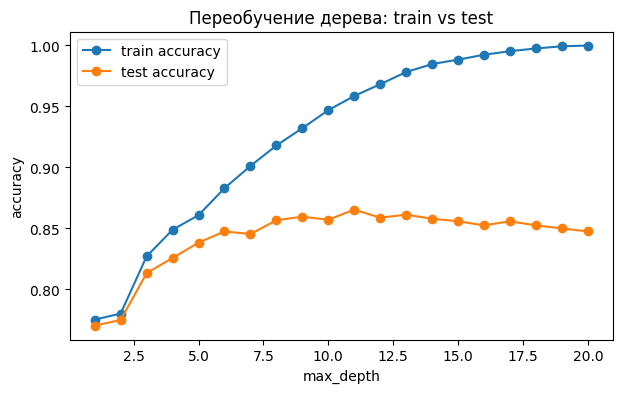

In [22]:
depths = list(range(1, 21))
train_acc = []
test_acc = []

for d in depths:
    m = DecisionTreeClassifier(max_depth=d, random_state=RANDOM_STATE)
    m.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, m.predict(X_train)))
    test_acc.append(accuracy_score(y_test, m.predict(X_test)))

# График “классика”: train растёт, test обычно имеет максимум и затем падает.
plt.figure(figsize=(7, 4))
plt.plot(depths, train_acc, marker="o", label="train accuracy")
plt.plot(depths, test_acc, marker="o", label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.title("Переобучение дерева: train vs test")
plt.legend()
plt.show()


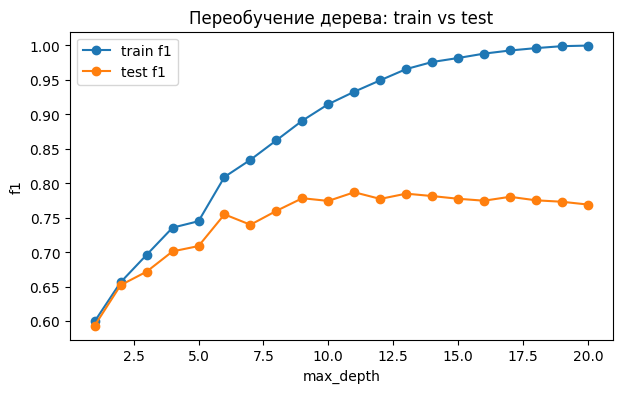

In [23]:
depths = list(range(1, 21))
train_f1 = []
test_f1 = []

for d in depths:
    m = DecisionTreeClassifier(max_depth=d, random_state=RANDOM_STATE)
    m.fit(X_train, y_train)
    train_f1.append(f1_score(y_train, m.predict(X_train)))
    test_f1.append(f1_score(y_test, m.predict(X_test)))

# График “классика”: train растёт, test обычно имеет максимум и затем падает.
plt.figure(figsize=(7, 4))
plt.plot(depths, train_f1, marker="o", label="train f1")
plt.plot(depths, test_f1, marker="o", label="test f1")
plt.xlabel("max_depth")
plt.ylabel("f1")
plt.title("Переобучение дерева: train vs test")
plt.legend()
plt.show()

In [24]:
tree_full = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=11,min_samples_leaf=10)
tree_full.fit(X_train, y_train)

# Сравним качество на train и test – это базовый способ “поймать” переобучение.
y_pred_train = tree_full.predict(X_train)
y_pred_test = tree_full.predict(X_test)

print_metrics(y_train, y_pred_train, title="max_depth=11,min_samples_leaf=10 TREE – train ")
print_metrics(y_test, y_pred_test, title="max_depth=11,min_samples_leaf=10 TREE – test ")

max_depth=11,min_samples_leaf=10 TREE – train 
accuracy = 0.9239
f1       = 0.8763
confusion_matrix:
[[4711  160]
 [ 388 1941]]

max_depth=11,min_samples_leaf=10 TREE – test 
accuracy = 0.8683
f1       = 0.7865
confusion_matrix:
[[1502  122]
 [ 194  582]]



In [27]:
path = tree_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Чтобы не плодить десятки почти одинаковых моделей:
# берём уникальные alpha и слегка прорежаем, если их слишком много.
ccp_alphas = np.unique(ccp_alphas)
if len(ccp_alphas) > 60:
    ccp_alphas = ccp_alphas[:: max(1, len(ccp_alphas)//60)]

train_scores = []
test_scores = []
node_counts = []

models = []
for a in ccp_alphas:
    # Чем больше ccp_alpha → тем сильнее обрезка (дерево меньше).
    m = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=float(a))
    m.fit(X_train, y_train)
    models.append(m)
    train_scores.append(f1_score(y_train, m.predict(X_train)))
    test_scores.append(f1_score(y_test, m.predict(X_test)))
    node_counts.append(m.tree_.node_count)

# Выбираем alpha по качеству на test (в реальном проекте обычно используют валидацию/CV).
best_idx = int(np.argmax(test_scores))
best_alpha = float(ccp_alphas[best_idx])
best_model = models[best_idx]

best_alpha, test_scores[best_idx], node_counts[best_idx]

(0.0003386243386243386, 0.7989623865110247, 437)

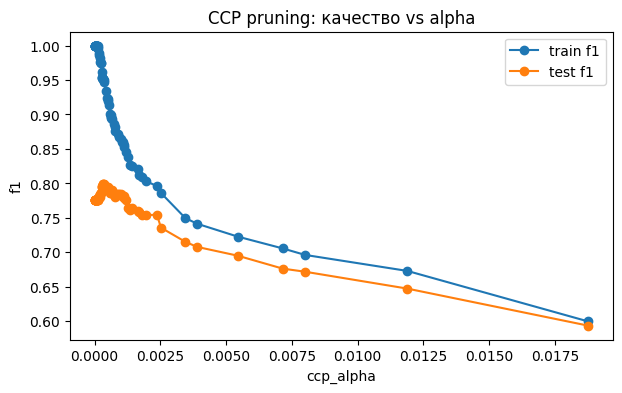

In [28]:
# Смотрим, как меняется качество при росте alpha (обрезке).
plt.figure(figsize=(7, 4))
plt.plot(ccp_alphas, train_scores, marker="o", label="train f1")
plt.plot(ccp_alphas, test_scores, marker="o", label="test f1")
plt.xlabel("ccp_alpha")
plt.ylabel("f1")
plt.title("CCP pruning: качество vs alpha")
plt.legend()
plt.show()

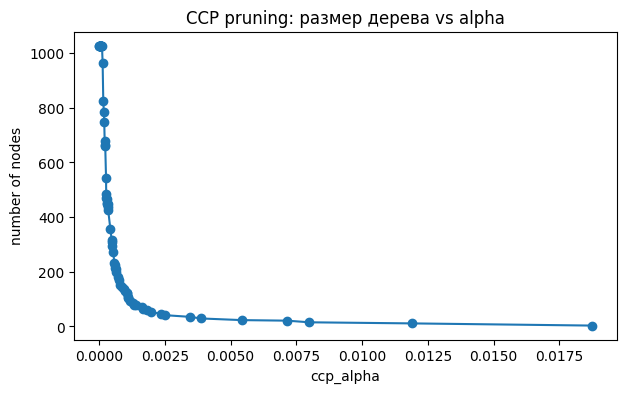

In [29]:
plt.figure(figsize=(7, 4))
plt.plot(ccp_alphas, node_counts, marker="o")
plt.xlabel("ccp_alpha")
plt.ylabel("number of nodes")
plt.title("CCP pruning: размер дерева vs alpha")
plt.show()

In [31]:
print(f"Лучшее alpha по test accuracy: {best_alpha}")
print_metrics(y_test, best_model.predict(X_test), title="BEST CCP TREE – test")


Лучшее alpha по test accuracy: 0.0003386243386243386
BEST CCP TREE – test
accuracy = 0.8708
f1       = 0.7990
confusion_matrix:
[[1474  150]
 [ 160  616]]



In [33]:
tree_full = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=11,min_samples_leaf=10, ccp_alpha=0.0003386243386243386)
tree_full.fit(X_train, y_train)

# Сравним качество на train и test – это базовый способ “поймать” переобучение.
y_pred_train = tree_full.predict(X_train)
y_pred_test = tree_full.predict(X_test)

print_metrics(y_train, y_pred_train, title="max_depth=11,min_samples_leaf=10 TREE – train ")
print_metrics(y_test, y_pred_test, title="max_depth=11,min_samples_leaf=10 TREE – test ")

max_depth=11,min_samples_leaf=10 TREE – train 
accuracy = 0.9233
f1       = 0.8762
confusion_matrix:
[[4694  177]
 [ 375 1954]]

max_depth=11,min_samples_leaf=10 TREE – test 
accuracy = 0.8688
f1       = 0.7887
confusion_matrix:
[[1497  127]
 [ 188  588]]



In [37]:
def make_bagging_tree(estimator, n_estimators=200, random_state=42, oob_score=True, n_jobs=-1):
    # совместимость с разными версиями sklearn
    try:
        return BaggingClassifier(
            estimator=estimator,
            n_estimators=n_estimators,
            bootstrap=True,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state
        )
    except TypeError:
        return BaggingClassifier(
            base_estimator=estimator,
            n_estimators=n_estimators,
            bootstrap=True,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state
        )


base_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=11,min_samples_leaf=10, ccp_alpha=0.0003386243386243386)

bag = make_bagging_tree(base_tree, n_estimators=250, random_state=RANDOM_STATE, oob_score=True, n_jobs=-1)
bag.fit(X_train, y_train)

print(f"Bagging oob_score_ = {getattr(bag, 'oob_score_', None)}")
print_metrics(y_test, bag.predict(X_test), title="Bagging(DecisionTree) – test")


Bagging oob_score_ = 0.9086111111111111
Bagging(DecisionTree) – test
accuracy = 0.9004
f1       = 0.8380
confusion_matrix:
[[1543   81]
 [ 158  618]]



In [38]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    oob_score=True,
    n_jobs=-1,
    # max_features="sqrt"  # по умолчанию для классификации обычно sqrt(n_features)
)
rf.fit(X_train, y_train)

print(f"RandomForest oob_score_ = {rf.oob_score_:.4f}")
print_metrics(y_test, rf.predict(X_test), title="RandomForest – test")

RandomForest oob_score_ = 0.9276
RandomForest – test
accuracy = 0.9233
f1       = 0.8747
confusion_matrix:
[[1574   50]
 [ 134  642]]



In [40]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict

# Метрики бинарной классификации
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# Базовые модели и инструменты пайплайна
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Ансамбли: boosting, (контекст) bagging, и stacking
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)

def eval_binary(model, X_train, y_train, X_test, y_test, title=None):
    # Мини-обёртка: обучить модель на train и оценить на test.
    # Возвращаем обученную модель – её удобно дальше использовать (например, рисовать границу).
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        # Для ROC-AUC нужна "уверенность" модели: вероятность положительного класса
        proba = model.predict_proba(X_test)[:, 1]
    print_metrics(y_test, pred, y_proba=proba, title=title)
    return model



In [43]:
stump = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=11,min_samples_leaf=10, ccp_alpha=0.0003386243386243386)


# Параметры AdaBoost:
# - n_estimators: сколько итераций (сколько слабых моделей будет в ансамбле)
# - learning_rate: вклад каждой итерации (шаг)
ada = AdaBoostClassifier(
    estimator=stump,
    n_estimators=200,
    learning_rate=0.6,
    random_state=RANDOM_STATE
)

# Обучаем и оцениваем на test (важно: именно на test!)
ada = eval_binary(ada, X_train, y_train, X_test, y_test, title="AdaBoost (stumps) – test")



AdaBoost (stumps) – test
accuracy = 0.9400
f1       = 0.9035
roc_auc  = 0.9736
confusion_matrix:
[[1582   42]
 [ 102  674]]




ОЦЕНКА ВСЕХ МОДЕЛЕЙ И СОХРАНЕНИЕ АРТЕФАКТОВ
✓ Метрики сохранены в: artifacts\metrics_test.json
✓ Сводки поиска сохранены в: artifacts\search_summaries.json
✓ Лучшая модель сохранена: RandomForest
✓ Метаданные сохранены в: artifacts\best_model_meta.json


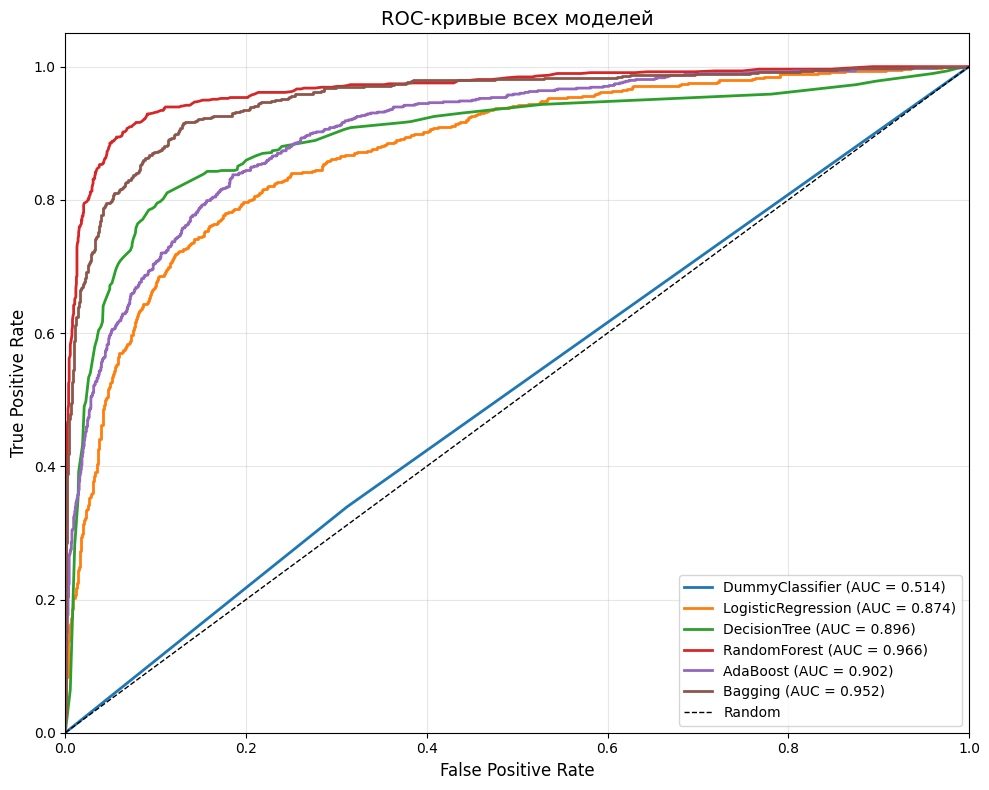

✓ ROC-кривые сохранены в: artifacts\figures\roc_curves_all.png


<Figure size 800x600 with 0 Axes>

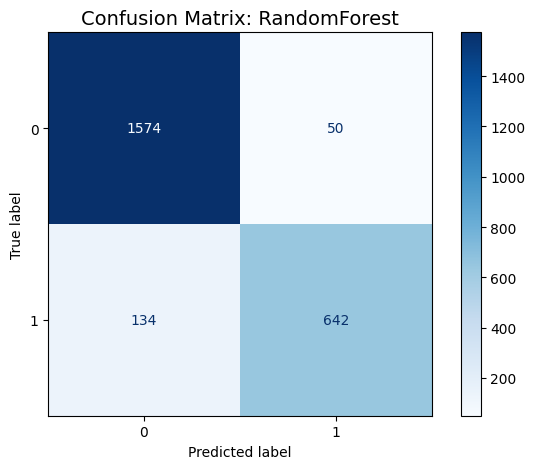

✓ Confusion matrix сохранена в: artifacts\figures\confusion_matrix_best.png


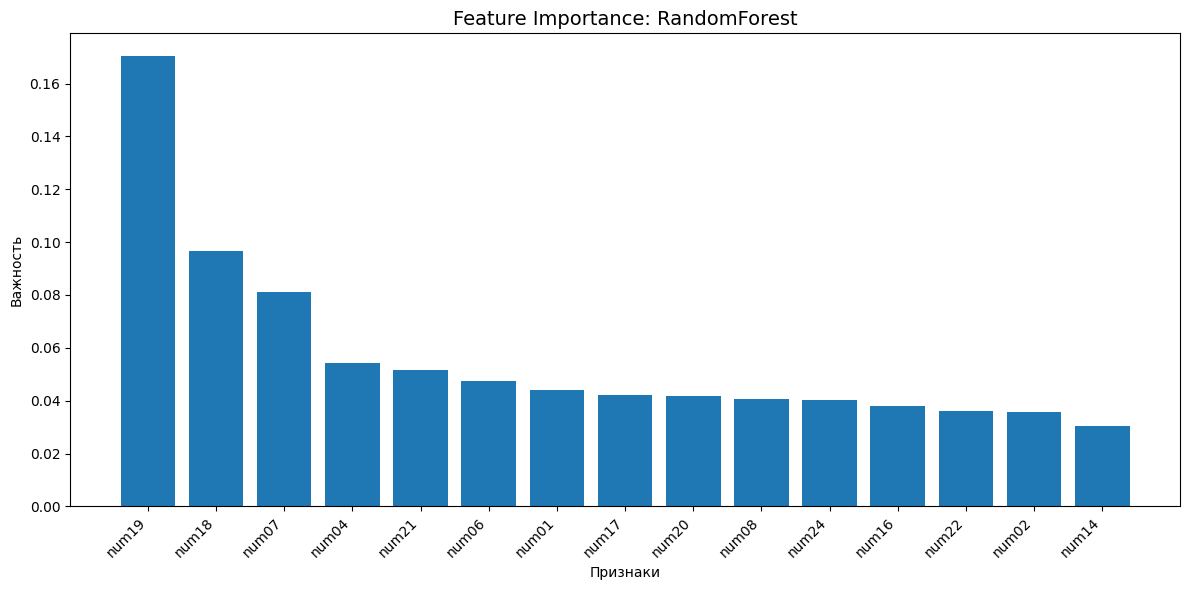

✓ Feature importance сохранена в: artifacts\figures\feature_importance_best.png


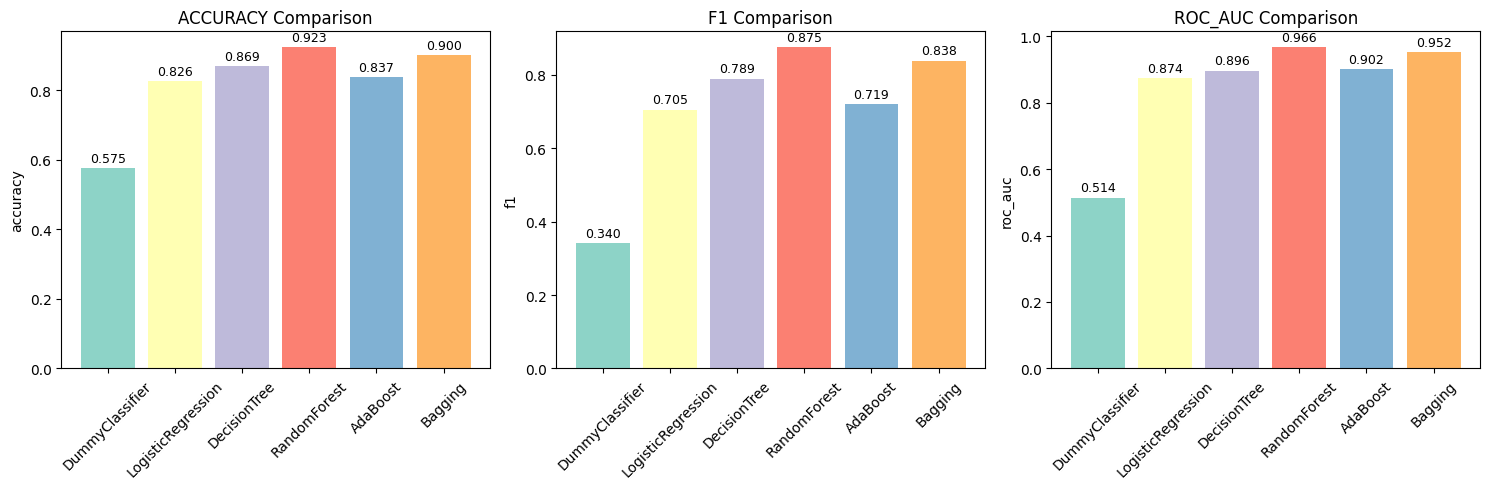

✓ Сравнение метрик сохранено в: artifacts\figures\metrics_comparison.png

ВСЕ АРТЕФАКТЫ УСПЕШНО СОХРАНЕНЫ!

ФИНАЛЬНЫЕ МЕТРИКИ НА TEST ДЛЯ ВСЕХ МОДЕЛЕЙ

DummyClassifier:
  Accuracy: 0.5754
  F1-score: 0.3405
  ROC-AUC:  0.5137

LogisticRegression:
  Accuracy: 0.8263
  F1-score: 0.7049
  ROC-AUC:  0.8738

DecisionTree:
  Accuracy: 0.8688
  F1-score: 0.7887
  ROC-AUC:  0.8959

RandomForest:
  Accuracy: 0.9233
  F1-score: 0.8747
  ROC-AUC:  0.9665

AdaBoost:
  Accuracy: 0.8371
  F1-score: 0.7193
  ROC-AUC:  0.9018

Bagging:
  Accuracy: 0.9004
  F1-score: 0.8380
  ROC-AUC:  0.9523

ЛУЧШАЯ МОДЕЛЬ: RandomForest
Лучший ROC-AUC: 0.9665


In [48]:
# === КОД ДЛЯ СОХРАНЕНИЯ АРТЕФАКТОВ ===

import json
import joblib
from pathlib import Path
from datetime import datetime

# Создаем папку для артефактов
artifacts_dir = Path("artifacts")

figures_dir = artifacts_dir / "figures"


# Словарь для сохранения результатов всех моделей
all_results = {}
best_model_info = {"model": None, "metrics": {}, "params": {}, "roc_auc": 0}

# Функция для оценки модели и сохранения результатов
def evaluate_and_save(model, model_name, X_train, y_train, X_test, y_test, params=None):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Вычисляем метрики
    metrics = {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "f1": float(f1_score(y_test, y_pred)),
        "roc_auc": float(roc_auc_score(y_test, y_proba)) if y_proba is not None else None
    }
    
    # Сохраняем confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Сохраняем в общий словарь
    all_results[model_name] = {
        "metrics": metrics,
        "params": params or {},
        "confusion_matrix": cm.tolist()
    }
    
    # Обновляем лучшую модель (по ROC-AUC)
    if metrics["roc_auc"] and metrics["roc_auc"] > best_model_info["roc_auc"]:
        best_model_info.update({
            "model": model,
            "model_name": model_name,
            "metrics": metrics,
            "params": params or {},
            "roc_auc": metrics["roc_auc"]
        })
    
    return model, metrics

# ============ ОЦЕНИВАЕМ ВСЕ МОДЕЛИ И СОХРАНЯЕМ РЕЗУЛЬТАТЫ ============

print("\n" + "="*60)
print("ОЦЕНКА ВСЕХ МОДЕЛЕЙ И СОХРАНЕНИЕ АРТЕФАКТОВ")
print("="*60)

# 1. Dummy Classifier
dummy_model = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
dummy_model, dummy_metrics = evaluate_and_save(
    dummy_model, "DummyClassifier", 
    X_train, y_train, X_test, y_test,
    params={"strategy": "stratified"}
)

# 2. Logistic Regression
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(penalty="l2", C=1.0, solver="liblinear", random_state=RANDOM_STATE))
])
logreg_model, logreg_metrics = evaluate_and_save(
    logreg_pipeline, "LogisticRegression",
    X_train, y_train, X_test, y_test,
    params={"penalty": "l2", "C": 1.0, "solver": "liblinear"}
)

# 3. Decision Tree (регуляризованный)
tree_model = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    max_depth=11,
    min_samples_leaf=10,
    ccp_alpha=0.0003386243386243386
)
tree_model, tree_metrics = evaluate_and_save(
    tree_model, "DecisionTree",
    X_train, y_train, X_test, y_test,
    params={"max_depth": 11, "min_samples_leaf": 10, "ccp_alpha": 0.0003386243386243386}
)

# 4. Random Forest
rf_model = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    oob_score=True,
    n_jobs=-1
)
rf_model, rf_metrics = evaluate_and_save(
    rf_model, "RandomForest",
    X_train, y_train, X_test, y_test,
    params={"n_estimators": 400, "max_features": "sqrt", "oob_score": True}
)

# 5. AdaBoost
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE),
    n_estimators=200,
    learning_rate=0.6,
    random_state=RANDOM_STATE
)
ada_model, ada_metrics = evaluate_and_save(
    ada_model, "AdaBoost",
    X_train, y_train, X_test, y_test,
    params={"n_estimators": 200, "learning_rate": 0.6, "base_estimator": "DecisionTree(max_depth=1)"}
)

# 6. Bagging
bag_model = make_bagging_tree(
    DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        max_depth=11,
        min_samples_leaf=10,
        ccp_alpha=0.0003386243386243386
    ),
    n_estimators=250,
    random_state=RANDOM_STATE,
    oob_score=True,
    n_jobs=-1
)
bag_model, bag_metrics = evaluate_and_save(
    bag_model, "Bagging",
    X_train, y_train, X_test, y_test,
    params={"n_estimators": 250, "bootstrap": True, "oob_score": True}
)

# ============ СОХРАНЕНИЕ МЕТРИК В ФАЙЛ ============

# 1. Сохраняем все метрики в JSON
metrics_dict = {}
for model_name, result in all_results.items():
    metrics_dict[model_name] = result["metrics"]

with open(artifacts_dir / "metrics_test.json", "w", encoding="utf-8") as f:
    json.dump(metrics_dict, f, indent=2, ensure_ascii=False)

print(f"✓ Метрики сохранены в: {artifacts_dir / 'metrics_test.json'}")

# 2. Сохраняем сводку поиска параметров (если был)
search_summaries = {
    "DecisionTree": {
        "best_params": {
            "max_depth": 11,
            "min_samples_leaf": 10,
            "ccp_alpha": 0.0003386243386243386
        },
        "cv_score_f1": tree_metrics["f1"],
        "notes": "Подбор через cost complexity pruning path"
    },
    "RandomForest": {
        "best_params": {"n_estimators": 400, "max_features": "sqrt"},
        "cv_score_f1": rf_metrics["f1"],
        "notes": "Fixed parameters, использован OOB score"
    }
}

with open(artifacts_dir / "search_summaries.json", "w", encoding="utf-8") as f:
    json.dump(search_summaries, f, indent=2, ensure_ascii=False)

print(f"✓ Сводки поиска сохранены в: {artifacts_dir / 'search_summaries.json'}")

# ============ СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ ============

# Сохраняем лучшую модель
joblib.dump(best_model_info["model"], artifacts_dir / "best_model.joblib")

# Метаданные лучшей модели
best_model_meta = {
    "best_model": best_model_info["model_name"],
    "best_params": best_model_info["params"],
    "test_metrics": best_model_info["metrics"],
    "saved_at": datetime.now().isoformat(),
    "random_state": RANDOM_STATE,
    "train_size": len(X_train),
    "test_size": len(X_test)
}

with open(artifacts_dir / "best_model_meta.json", "w", encoding="utf-8") as f:
    json.dump(best_model_meta, f, indent=2, ensure_ascii=False)

print(f"✓ Лучшая модель сохранена: {best_model_info['model_name']}")
print(f"✓ Метаданные сохранены в: {artifacts_dir / 'best_model_meta.json'}")

# ============ СОЗДАНИЕ ВИЗУАЛИЗАЦИЙ ============

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# 1. ROC-кривая для всех моделей
plt.figure(figsize=(10, 8))
for model_name, result in all_results.items():
    if "roc_auc" in result["metrics"] and result["metrics"]["roc_auc"]:
        # Получаем модель и предсказания
        if model_name == "DummyClassifier":
            model = dummy_model
        elif model_name == "LogisticRegression":
            model = logreg_model
        elif model_name == "DecisionTree":
            model = tree_model
        elif model_name == "RandomForest":
            model = rf_model
        elif model_name == "AdaBoost":
            model = ada_model
        elif model_name == "Bagging":
            model = bag_model
        
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, 
                    label=f'{model_name} (AUC = {roc_auc:.3f})',
                    linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривые всех моделей', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(figures_dir / "roc_curves_all.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ROC-кривые сохранены в: {figures_dir / 'roc_curves_all.png'}")

# 2. Confusion Matrix для лучшей модели
plt.figure(figsize=(8, 6))
best_model = best_model_info["model"]
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f'Confusion Matrix: {best_model_info["model_name"]}', fontsize=14)
plt.tight_layout()
plt.savefig(figures_dir / "confusion_matrix_best.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrix сохранена в: {figures_dir / 'confusion_matrix_best.png'}")

# 3. Feature Importance для деревьев
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(12, 6))
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1][:15]
    
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [X.columns[i] for i in indices], rotation=45, ha='right')
    plt.xlabel('Признаки')
    plt.ylabel('Важность')
    plt.title(f'Feature Importance: {best_model_info["model_name"]}', fontsize=14)
    plt.tight_layout()
    plt.savefig(figures_dir / "feature_importance_best.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Feature importance сохранена в: {figures_dir / 'feature_importance_best.png'}")

# 4. Сравнение метрик всех моделей (барплот)
metrics_comparison = pd.DataFrame({
    model: all_results[model]["metrics"] 
    for model in all_results.keys()
}).T

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics_to_plot = ['accuracy', 'f1', 'roc_auc']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    metric_data = metrics_comparison[metric].dropna()
    if len(metric_data) > 0:
        colors = plt.cm.Set3(np.arange(len(metric_data)))
        bars = ax.bar(metric_data.index, metric_data.values, color=colors)
        ax.set_title(f'{metric.upper()} Comparison', fontsize=12)
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        
        # Добавляем значения на бары
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(figures_dir / "metrics_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Сравнение метрик сохранено в: {figures_dir / 'metrics_comparison.png'}")

print("\n" + "="*60)
print("ВСЕ АРТЕФАКТЫ УСПЕШНО СОХРАНЕНЫ!")
print("="*60)

# ============ ВЫВОД ИТОГОВЫХ МЕТРИК ============

print("\n" + "="*60)
print("ФИНАЛЬНЫЕ МЕТРИКИ НА TEST ДЛЯ ВСЕХ МОДЕЛЕЙ")
print("="*60)

for model_name in all_results.keys():
    metrics = all_results[model_name]["metrics"]
    print(f"\n{model_name}:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  F1-score: {metrics['f1']:.4f}")
    if metrics.get('roc_auc'):
        print(f"  ROC-AUC:  {metrics['roc_auc']:.4f}")

print("\n" + "="*60)
print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_info['model_name']}")
print(f"Лучший ROC-AUC: {best_model_info['metrics']['roc_auc']:.4f}")
print("="*60)

In [47]:


# Для табличных данных сразу используем регуляризованное дерево (как более “здравый” baseline).
tree = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=11,min_samples_leaf=10, ccp_alpha=0.0003386243386243386)

tree.fit(X_train, y_train)

# Для ROC-AUC нам нужны вероятности.
proba_test = tree.predict_proba(X_test)[:, 1]
# Для метрик по классам (accuracy/F1) берём стандартный порог 0.5.
pred_test = (proba_test >= 0.5).astype(int)

print_metrics(y_test, pred_test, y_proba=proba_test, title="DecisionTree")


perm = permutation_importance(
    tree, X_test, y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="accuracy"
)

importances = perm.importances_mean
# Сортируем признаки по важности (убывание) и возьмём top-12 для наглядного графика.
idx = np.argsort(importances)[::-1][:10]

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std,
    'importances': perm.importances.tolist()  # все значения перестановок
})

# Сортировка по важности
importance_df = importance_df.sort_values('importance_mean', ascending=False)
print(importance_df)


DecisionTree
accuracy = 0.8696
f1       = 0.7912
roc_auc  = 0.8959
confusion_matrix:
[[1494  130]
 [ 183  593]]

          feature  importance_mean  importance_std  \
18          num19         0.132583        0.007723   
17          num18         0.085708        0.003918   
6           num07         0.072708        0.004311   
3           num04         0.038000        0.003974   
19          num20         0.035667        0.002695   
0           num01         0.032625        0.003953   
23          num24         0.020000        0.003395   
20          num21         0.017583        0.002392   
21          num22         0.017375        0.002313   
13          num14         0.014417        0.001516   
5           num06         0.013083        0.001983   
16          num17         0.012542        0.002368   
15          num16         0.012333        0.002167   
7           num08         0.008917        0.001974   
12          num13         0.007833        0.001523   
1           num02      